In [1]:
from emergent_models.core.state import StateModel
from emergent_models.rules.sanitization import lut_idx
from emergent_models.core.space_model import Tape1D
from emergent_models.encoders.em43 import Em43Encoder
from emergent_models.simulation.simulator import Simulator
from emergent_models.training.new_fitness import AbsoluteDifferenceFitness
from emergent_models.training import (Trainer,
                                      ComplexityRewardFitness,
                    SparsityPenalizedFitness, GAOptimizer)
from emergent_models.training import TqdmMonitor, DetailedMonitor, CombinedMonitor
from tqdm.notebook import tqdm
import numpy as np


In [9]:

print("🔬 Setting up investigation...")

# ═══════════════════ HYPERPARAMETERS ═══════════════════
POP_SIZE      = 5
N_GENERATIONS = 10
ELITE_FRAC    = 0.1
TOURNEY_K     = 3
P_MUT_RULE    = 0.03
P_MUT_PROG    = 0.08
L_PROG        = 10
LAMBDA_P      = 0.01
EPS_RANDOM_IMMIGRANTS = 0.2
N_COMPLEX_TELEMETRY   = 30
INPUT_SET     = np.arange(1, 31, dtype=np.int64)
TARGET_OUT    = 2 * INPUT_SET
WINDOW        = 200
MAX_STEPS     = 800
HALT_THRESH   = 0.50
CHECK_EVERY   = 50


# 1. Domain setup
_IMMUTABLE = {
    lut_idx(0, 0, 0): 0,  # Empty space stays empty
    lut_idx(0, 2, 0): 2,  # Red beacon propagation
    lut_idx(0, 0, 2): 0,  # Red beacon boundary
    lut_idx(2, 0, 0): 0,  # Red beacon boundary  
    lut_idx(0, 3, 3): 3,  # Blue boundary behavior
    lut_idx(3, 3, 0): 3,  # Blue boundary behavior
    lut_idx(0, 0, 3): 0,  # Blue boundary behavior
    lut_idx(3, 0, 0): 0,  # Blue boundary behavior
}
state = StateModel([0,1,2,3], immutable=_IMMUTABLE)
space = Tape1D(length=WINDOW, radius=1)
encoder = Em43Encoder(state, space)


# 2. Simulation
sim = Simulator(
    state=state, 
    space=space, 
    max_steps=MAX_STEPS,                                    # MAX_STEPS
    halt_thresh=HALT_THRESH                                 # HALT_THRESH
)

# Usage
base_fitness = AbsoluteDifferenceFitness(continuous=True)

fitness = ComplexityRewardFitness(
    base_fitness, 
    complexity_bonus=0.05
)


# Combine tqdm with detailed logging
tqdm_monitor = TqdmMonitor(N_GENERATIONS)
detailed_monitor = DetailedMonitor(log_every=10, detailed_every=30)
combined = CombinedMonitor(tqdm_monitor, detailed_monitor)

# 4. Optimizer with all GA parameters
optim = GAOptimizer(
    pop_size=POP_SIZE,                                      # POP_SIZE
    state=state,
    prog_len=L_PROG,                                        # L_PROG
    mutation_rate=P_MUT_RULE,                               # P_MUT_RULE
    prog_mutation_rate=P_MUT_PROG,                          # P_MUT_PROG
    elite_fraction=ELITE_FRAC,                              # ELITE_FRAC
    tournament_size=TOURNEY_K,                              # TOURNEY_K
    random_immigrant_rate=EPS_RANDOM_IMMIGRANTS,            # EPS_RANDOM_IMMIGRANTS
    prog_sparsity=0.3
)

# 3. Training
trainer = Trainer(encoder, sim, fitness, optim, combined)



print("✅ Setup complete!")


🔬 Setting up investigation...
🚀 Pre-allocated evaluation buffers: pop_size=5, table_size=64, prog_len=10
✅ Setup complete!


In [10]:
print("🚀 Starting training with tqdm progress bar...")
inputs = np.random.randint(1, 30, size=POP_SIZE).reshape(-1, 1)
targets = 2 * inputs
print(inputs.shape, targets.shape)


🚀 Starting training with tqdm progress bar...
(5, 1) (5, 1)


####
# Preparing Initial State from Input Data
###

input data dims: batch_size x single_inp_dim (B, D1, D2, ...)
Let's focus on 1-D inputs for now.
then input data dims: batch_size x single_inp_dim (B, D1)

program dim for 1-D tape: population_size x programme_length (P, L)
Tape dims: population_size x tape_length (P, T) where T > D1 + L + offset


Ideally, the encoded training data should have dims: (B, P, T)
For simplicity let's make batch is implicitly the population size.
so, the training input should have dims: (P, T)



In [11]:
population = trainer.optimizer.ask()
population[:3]

[Genome(rule_size=64, prog_length=10, fitness=0.0000),
 Genome(rule_size=64, prog_length=10, fitness=0.0000),
 Genome(rule_size=64, prog_length=10, fitness=0.0000)]

In [12]:
population[0].programme.code

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 2], dtype=uint8)

In [13]:

def _extract_population_data_fast(genomes) -> tuple[np.ndarray, np.ndarray]:
    """
    Fast extraction of population data into pre-allocated buffers.

    This method optimizes the data extraction bottleneck by minimizing
    Python loops and using vectorized operations where possible.
    """
    
    prog_len = L_PROG

    # Determine rule table size (assumes 4-state, 3-neighborhood = 64 entries)
    n_states = state.n_states
    table_size = n_states ** 3
    pop_size = len(genomes)
    _rule_buffer = np.zeros((pop_size, table_size), dtype=np.uint8)
    _prog_buffer = np.zeros((pop_size, prog_len), dtype=np.uint8)
    # Extract rule tables and programmes in optimized loop
    for i in range(pop_size):
        # Direct array assignment (faster than individual element access)
        np.copyto(_rule_buffer[i], genomes[i].rule.table)
        np.copyto(_prog_buffer[i], genomes[i].programme.code)
    return _rule_buffer, _prog_buffer

def _lut_idx(left, center, right):
    return (left << 4) | (center << 2) | right

def step_1d(tape, rule_table):
    length = len(tape)
    next_tape = np.zeros(length, dtype=np.uint8)
    
    # Boundary cells stay 0
    next_tape[0] = 0
    next_tape[length-1] = 0
    
    # Apply rules to interior cells
    for x in range(1, length - 1):
        left = tape[x - 1]
        center = tape[x]
        right = tape[x + 1]
        
        # Lookup table index
        idx = (left << 4) | (center << 2) | right
        if idx < len(rule_table):
            next_tape[x] = rule_table[idx]
    return next_tape

In [14]:
rules, progs = _extract_population_data_fast(population)

In [15]:
inputs.shape

(5, 1)

In [16]:
encoded_data = encoder.encode_population(progs, inputs)

In [17]:
encoded_data.shape

(5, 200)

In [18]:
inputs[:4]

array([[19],
       [19],
       [ 9],
       [ 5]])

In [19]:
decoded_data = encoder.decode_population(encoded_data, L_PROG)

In [24]:
decoded_data

array([19, 19,  9,  5,  5], dtype=int32)

In [21]:
final_state = sim.run_batch(encoded_data, rules[:POP_SIZE])


In [22]:
encoder.decode_population(final_state, L_PROG)[:40]

array([19, 19,  9,  5,  5], dtype=int32)

In [35]:
single_tape = encoded_data[0]
encoder.decode(sim.run(single_tape, rules[0]), L_PROG)

21

In [ ]:
batch_idx = 2
single_input = inputs[batch_idx]
single_tape = encoded_data[batch_idx]
print(single_input)
print(rules[batch_idx])
for step in range(10):
    single_tape = step_1d(single_tape, rules[batch_idx])
    print(encoder.decode(single_tape, L_PROG))
    if sim._check_halt(single_tape):
        live_count = np.count_nonzero(single_tape)
        if live_count == 0:
            print("HALTED (no live cells)")
        
        blue_count = np.count_nonzero(single_tape == 3)
        blue_fraction = blue_count / live_count
        print(blue_count, live_count, blue_fraction)
        print("HALTED")
        break

[27]
[0 3 0 0 0 1 0 2 2 0 2 2 3 0 2 3 3 3 3 3 2 2 3 3 2 2 1 2 1 3 0 3 0 0 1 0 0
 0 0 3 1 3 0 1 0 0 0 3 0 0 1 0 3 0 2 1 3 2 3 2 3 0 0 2]
27
4 7 0.5714285714285714
HALTED


In [59]:
idx = _lut_idx(3, 0, 3)
rules[batch_idx][idx]

np.uint8(0)

In [30]:
decoded_output =encoder.decode_population(final_state, L_PROG)

In [31]:
decoded_output[:40]

array([21, 14, 27, 14,  4, 19, 10,  9, 19, 26, 10, 28, 15,  9, 24, 13, 27,
       26, 24,  6,  5, 26,  4,  5,  7,  9, 28,  3, 21,  5, 27,  6,  1, 17,
       11, 22, 17,  0, 29,  1], dtype=int32)

In [31]:
from typing import Optional
from emergent_models.visualization.progression import ProgressionVisualizer
from emergent_models.visualization.tape import TapeVisualizer
from matplotlib import pyplot as plt

In [32]:

# Set up matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

def debug_single_genome_evolution(programme: np.ndarray, 
                                 input_val: int,
                                 rule_table: np.ndarray,
                                 max_steps: int = 20,
                                 halt_thresh: float = 0.5,
                                 window_size: int = 50,
                                 zoom_range: Optional[tuple] = None,
                                 show_step_by_step: bool = True):
    """
    Debug single genome CA evolution with step-by-step visualization.
    
    Parameters
    ----------
    programme : np.ndarray
        Programme array (e.g., [1, 2, 1])
    input_val : int
        Input value to encode
    rule_table : np.ndarray
        64-element rule lookup table
    max_steps : int, default=20
        Maximum simulation steps
    halt_thresh : float, default=0.5
        Halting threshold (fraction of blue cells)
    window_size : int, default=50
        CA tape window size
    zoom_range : tuple, optional
        (start, end) positions to focus on
    show_step_by_step : bool, default=True
        Whether to show individual step visualizations
    """
    
    print("🔬 CA Evolution Debugger")
    print("=" * 50)
    
    state = StateModel([0,1,2,3], immutable=_IMMUTABLE)
    space = Tape1D(window_size, radius=1)
    encoder = Em43Encoder(state, space)
    simulator = Simulator(state=state, space=space, max_steps=max_steps, halt_thresh=halt_thresh)
    
    # Create visualizers
    tape_viz = TapeVisualizer(state, backend="matplotlib")
    prog_viz = ProgressionVisualizer(state, backend="matplotlib")
    
    print(f"📝 Programme: {programme}")
    print(f"📥 Input: {input_val}")
    print(f"🎯 Rule table (first 10): {rule_table[:10]}...")
    print(f"⏱️  Max steps: {max_steps}")
    print(f"🛑 Halt threshold: {halt_thresh}")
    print()
    
    # Encode initial tape
    initial_tape = encoder.encode(programme, input_val)
    print(f"🎬 Initial tape (first 20 cells): {initial_tape[:20]}")
    
    # Calculate expected positions
    prog_len = len(programme)
    separator_pos = prog_len + 2
    beacon_pos = prog_len + 2 + input_val + 1
    print(f"📍 Programme: [0:{prog_len}], Separator: [{prog_len}:{separator_pos}], Beacon: {beacon_pos}")
    print()
    
    # Run step-by-step simulation
    evolution_history = []
    current_tape = initial_tape.copy()
    evolution_history.append(current_tape.copy())
    
    halted = False
    halt_step = None
    
    print("🚀 Starting simulation...")
    for step in range(max_steps):
        # Apply one CA step
        next_tape = simulator._step_kernel(current_tape, rule_table)
        evolution_history.append(next_tape.copy())
        
        # Check halting condition
        blue_count = np.count_nonzero(next_tape == 3)
        live_count = np.count_nonzero(next_tape)
        
        if live_count > 0:
            blue_fraction = blue_count / live_count
            print(f"Step {step+1:2d}: Live={live_count:2d}, Blue={blue_count:2d}, Fraction={blue_fraction:.3f}", end="")
            
            if blue_fraction >= halt_thresh:
                print(" 🛑 HALTED!")
                halted = True
                halt_step = step + 1
                break
            else:
                print()
        else:
            print(f"Step {step+1:2d}: All cells dead ☠️")
            break
        
        current_tape = next_tape
    
    print()
    if halted:
        print(f"✅ Simulation halted at step {halt_step}")
    else:
        print(f"⏰ Simulation completed without halting ({len(evolution_history)-1} steps)")
    
    # Show individual step visualizations
    if show_step_by_step and len(evolution_history) <= 10:
        print("\n📊 Step-by-step tape states:")
        fig, axes = plt.subplots(min(len(evolution_history), 5), 1, figsize=(15, 2*min(len(evolution_history), 5)))
        if len(evolution_history) == 1:
            axes = [axes]
        
        for i, tape in enumerate(evolution_history[:5]):  # Show first 5 steps
            ax = axes[i] if i < len(axes) else None
            if ax is not None:
                # Create simple bar visualization
                colors = ['black', 'white', 'red', 'blue']
                tape_colors = [colors[state] for state in tape[:30]]  # Show first 30 cells
                
                ax.bar(range(len(tape_colors)), [1]*len(tape_colors), color=tape_colors, 
                      edgecolor='gray', linewidth=0.5)
                ax.set_title(f"Step {i}")
                ax.set_xlim(-0.5, len(tape_colors)-0.5)
                ax.set_ylim(0, 1)
                ax.set_ylabel('State')
                
                # Add annotations
                ax.axvline(prog_len-0.5, color='green', alpha=0.7, linestyle='--', label='Prog End')
                ax.axvline(separator_pos-0.5, color='orange', alpha=0.7, linestyle='--', label='Sep End')
                ax.axvline(beacon_pos, color='purple', alpha=0.7, linestyle='-', linewidth=2, label='Beacon')
                
                if i == 0:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    # Create 2D space-time visualization
    print("\n🎨 2D Space-Time Evolution Map:")
    
    # Apply zoom if specified
    display_range = zoom_range if zoom_range else (0, min(50, len(initial_tape)))
    
    fig = prog_viz.render(
        evolution_history,
        title=f"CA Evolution: Programme={programme}, Input={input_val}",
        prog_len=prog_len,
        input_val=input_val,
        zoom_range=display_range,
        show_annotations=True,
        figsize=(15, 8)
    )
    
    plt.show()
    
    # Decode final output
    final_tape = evolution_history[-1]
    decoded_output = encoder.decode(final_tape, prog_len)
    expected_output = input_val * 2  # For doubling task
    
    print(f"\n🎯 Results:")
    print(f"   Input: {input_val}")
    print(f"   Decoded output: {decoded_output}")
    print(f"   Expected (2×input): {expected_output}")
    print(f"   Correct: {'✅' if decoded_output == expected_output else '❌'}")
    
    return evolution_history, decoded_output


🔬 CA Evolution Debugger
📝 Programme: [0 0 0 0 1 1 2 0 0 0]
📥 Input: [19]
🎯 Rule table (first 10): [0 1 0 0 1 2 0 2 2 3]...
⏱️  Max steps: 20
🛑 Halt threshold: 0.5

🎬 Initial tape (first 20 cells): [0 0 0 0 1 1 2 0 0 0 3 3 0 0 0 0 0 0 0 0]
📍 Programme: [0:10], Separator: [10:12], Beacon: [32]

🚀 Starting simulation...
Step  1: Live= 6, Blue= 2, Fraction=0.333
Step  2: Live= 7, Blue= 3, Fraction=0.429
Step  3: Live= 8, Blue= 2, Fraction=0.250
Step  4: Live= 8, Blue= 3, Fraction=0.375
Step  5: Live= 7, Blue= 4, Fraction=0.571 🛑 HALTED!

✅ Simulation halted at step 5

📊 Step-by-step tape states:


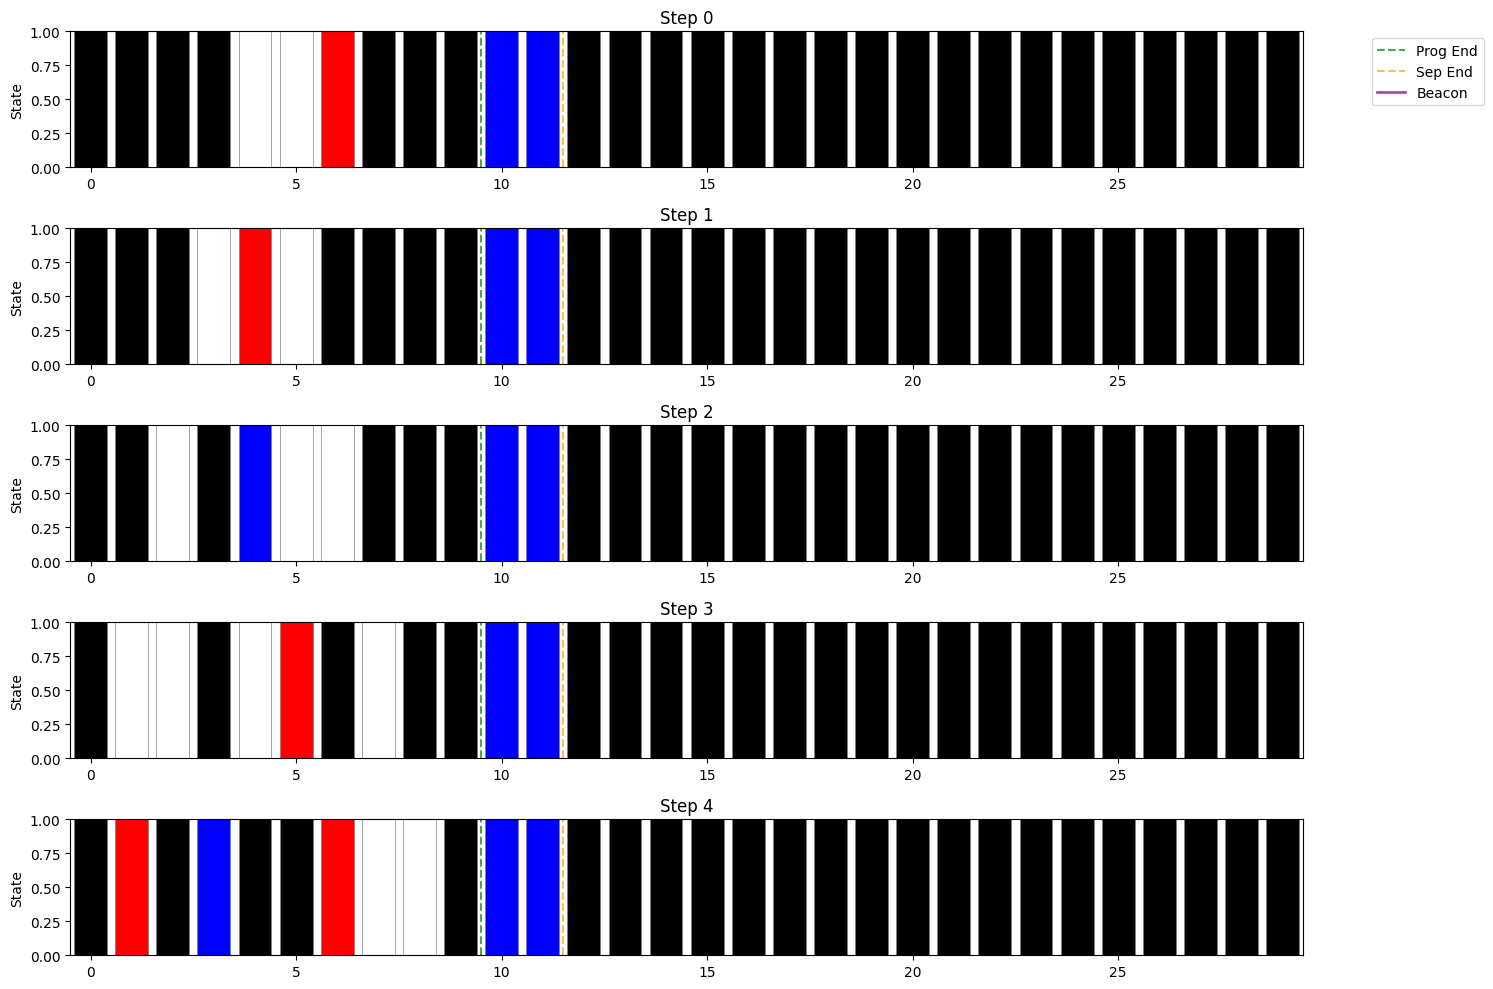


🎨 2D Space-Time Evolution Map:


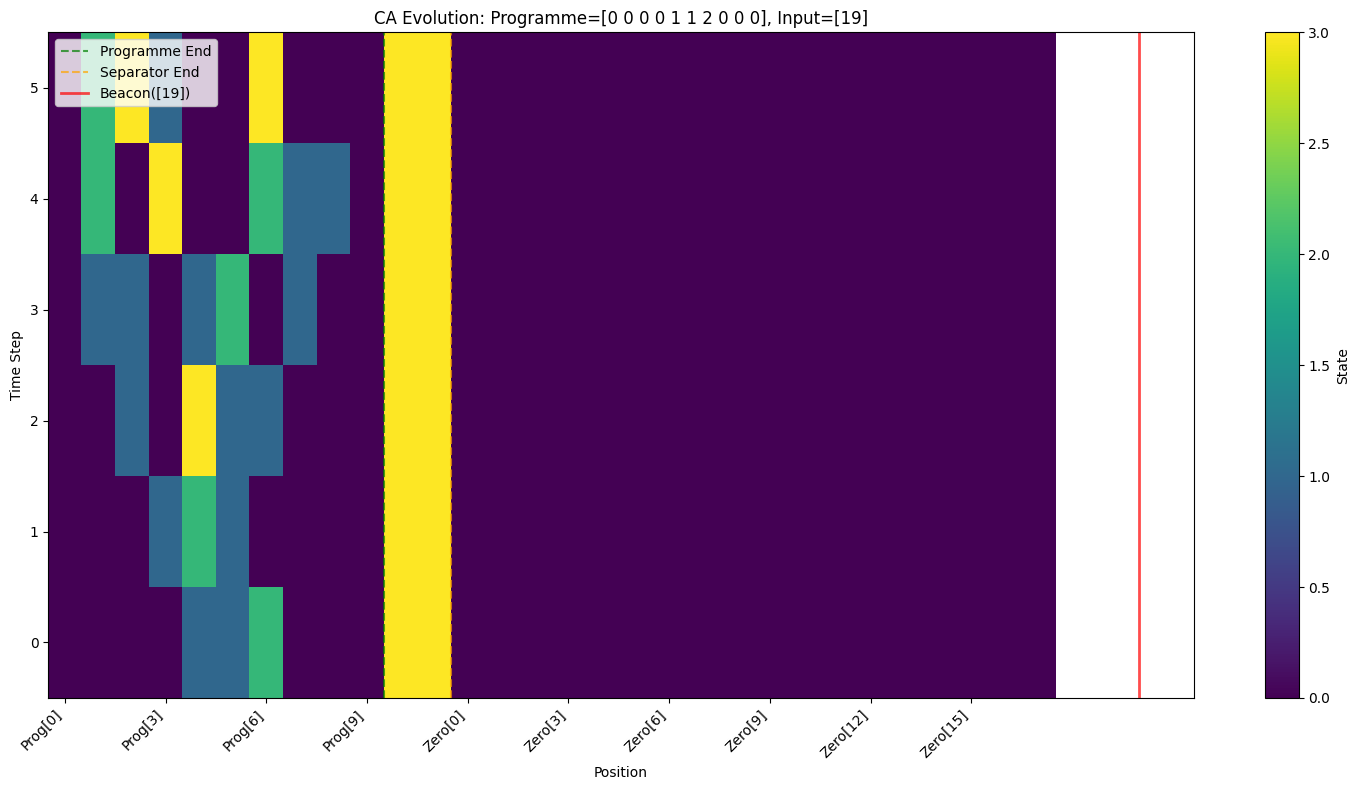


🎯 Results:
   Input: [19]
   Decoded output: 19
   Expected (2×input): [38]
   Correct: ❌


In [35]:

batch_idx = 1
# 3. Run the cell to see the visualization
history, output = debug_single_genome_evolution(
    programme=progs[batch_idx],
    input_val=inputs[batch_idx], 
    rule_table=rules[batch_idx],
    max_steps=20,
    zoom_range=(0, 30)  # Focus on first 30 cells
)

In [ ]:

# This should now show a nice progress bar!
result = trainer.fit(
    inputs=inputs,  # Smaller input set for demo
    targets=targets,
    generations=N_GENERATIONS,           # Fewer generations for demo
    use_tqdm=False,          # Don't add another tqdm (we already have one in monitor)
    checkpoint_every=CHECK_EVERY,
    early_stopping_threshold=1.00
)

print(f"✅ Training completed! Best fitness: {result['best_fitness']:.4f}")

In [11]:
population = trainer.optimizer.ask()

In [12]:
scores = trainer.evaluate_population(population, np.arange(30, 40))
print(f"Best score in population: {np.max(scores)}")
print(f"Number with score > 0: {np.sum(scores > 0)}")

Best score in population: 0.05000000074505806
Number with score > 0: 1389


In [13]:
analyze_population(population)

👥 POPULATION ANALYSIS
Population size: 5000
Unique programmes: 2976/5000 (59.5%)
Programme sparsity: 0.785 ± 0.265
Unique rules: 4993/5000 (99.9%)

Sample programmes:
  1: [2 2 2 1 1 1 1 1 2 1] (sparsity: 1.00)
  2: [1 2 1 2 2 2 2 2 2 1] (sparsity: 1.00)
  3: [2 2 1 1 2 1 1 2 2 1] (sparsity: 1.00)
  4: [1 2 1 1 1 2 2 1 1 1] (sparsity: 1.00)
  5: [1 2 1 1 2 1 2 2 1 1] (sparsity: 1.00)


In [14]:
genome = trainer.optimizer.best_genome()


🔧 ENCODING TEST
Input: 10
Programme length: 10
Expected separator (BB) at: [10, 11]
Expected beacon (R) at: 23

Actual structure:
  Programme: [2 2 2 1 1 1 1 1 2 1]
  Separator: [3 3]
  Beacon at 23: 2

Verification:
  Separator OK: ✅
  Beacon OK: ✅


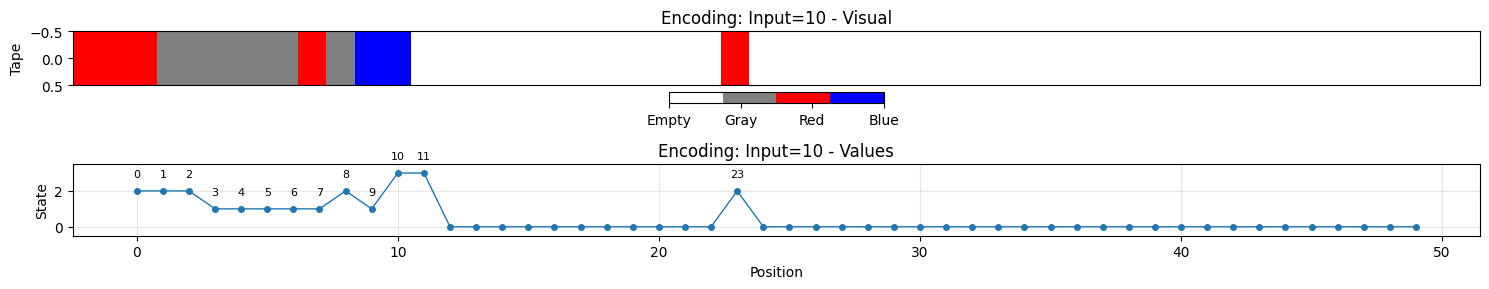

In [16]:
tape = test_encoding(encoder, genome.programme.code, input_val=10)

🔍 GENOME ANALYSIS
Programme: [2 2 2 1 1 1 1 1 2 1]
Programme length: 10
Programme sparsity: 1.000

Rule table length: 64
Rule table sample (first 16): [0 3 0 0 0 2 3 3 2 3 3 3 0 3 3 3]

Immutable constraints: 8
  ✓ LUT[ 0] = 0 (expected 0)
  ✓ LUT[ 8] = 2 (expected 2)
  ✓ LUT[ 2] = 0 (expected 0)
  ✓ LUT[32] = 0 (expected 0)
  ✓ LUT[15] = 3 (expected 3)
  ✓ LUT[60] = 3 (expected 3)
  ✓ LUT[ 3] = 0 (expected 0)
  ✓ LUT[48] = 0 (expected 0)

🔧 ENCODING TEST
Input: 3
Programme length: 10
Expected separator (BB) at: [10, 11]
Expected beacon (R) at: 16

Actual structure:
  Programme: [2 2 2 1 1 1 1 1 2 1]
  Separator: [3 3]
  Beacon at 16: 2

Verification:
  Separator OK: ✅
  Beacon OK: ✅

⚙️ SIMULATION
Initial non-zero positions: [ 0  1  2  3  4  5  6  7  8  9 10 11 16]
Step 1: 5 changes, non-zero: [ 1  2  3  4  5  6  7  8  9 10 11 16]
Step 2: 7 changes, non-zero: [ 1  2  3  4  5  6  7  8  9 10 11 16]
Step 3: 8 changes, non-zero: [ 1  2  3  4  5  6  7  8  9 10 11 12 16]
Step 4: 10 changes,

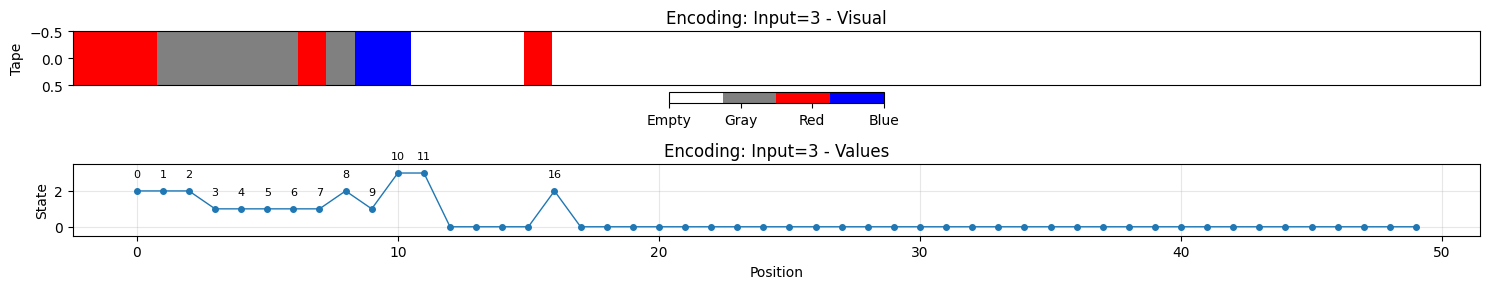

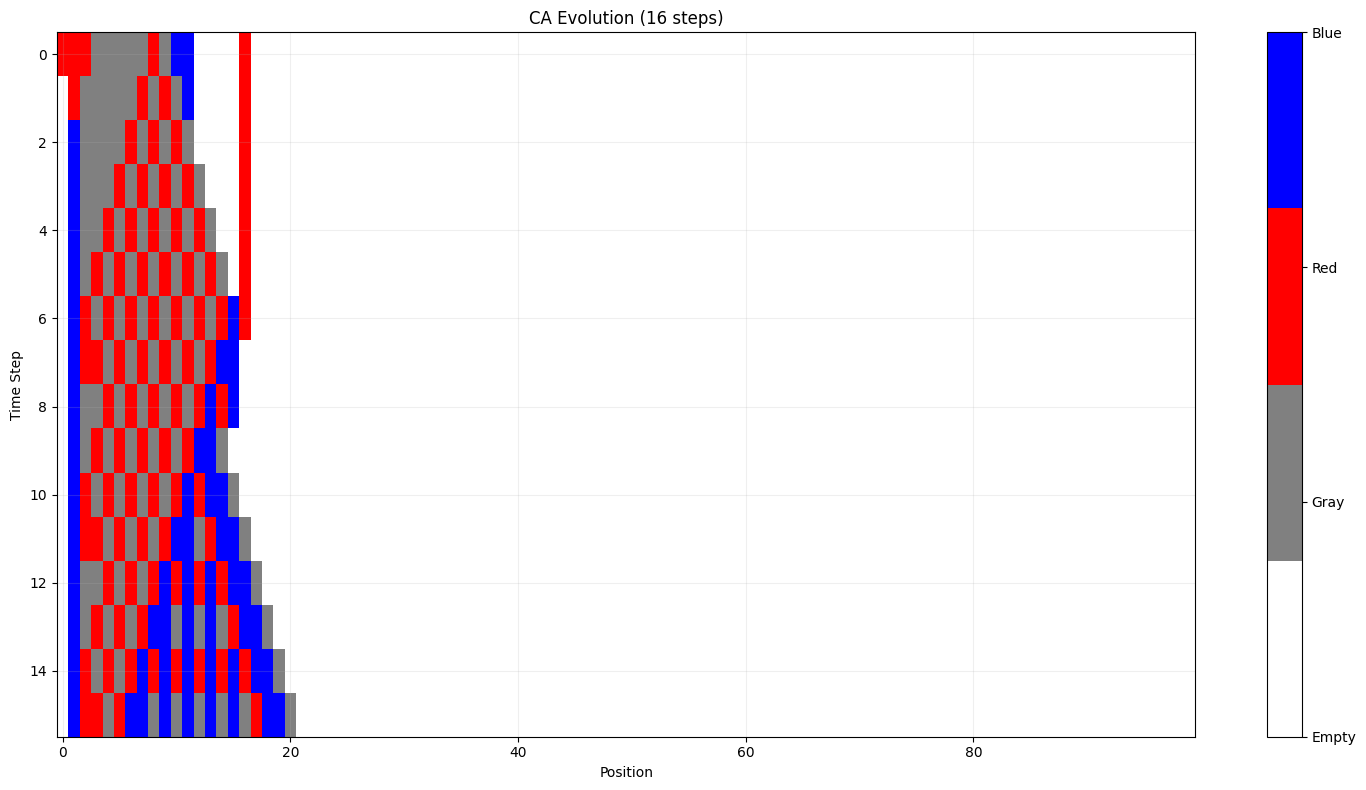

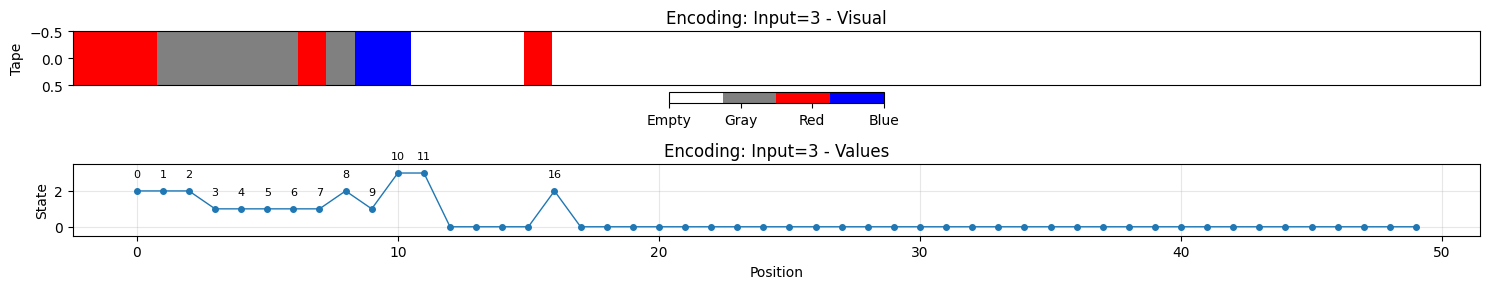

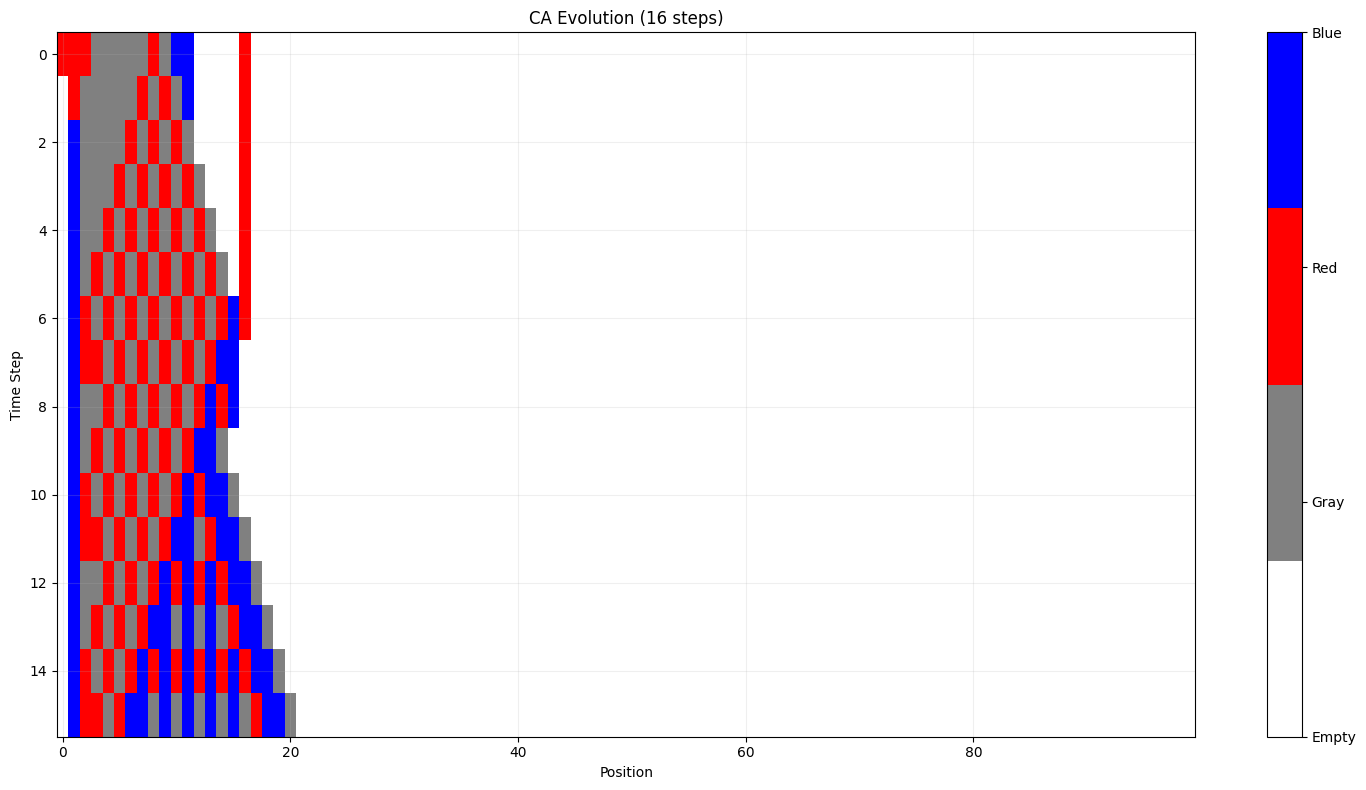

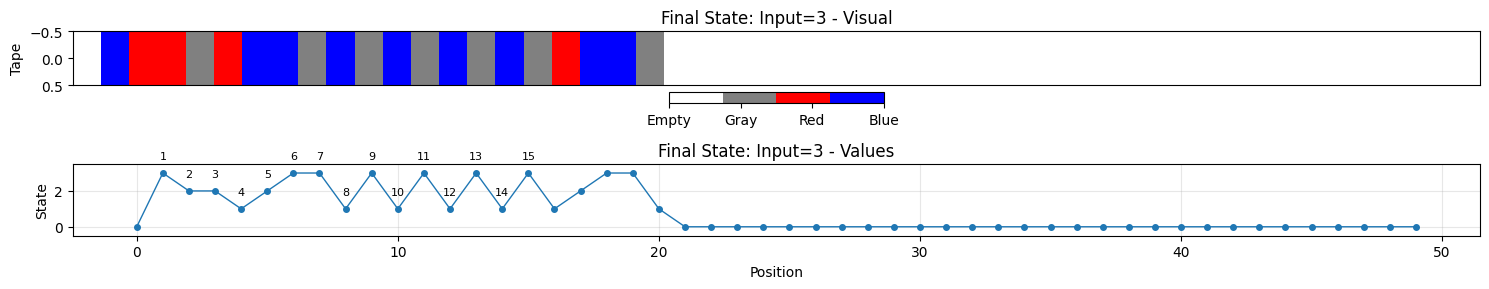

In [23]:
# Get the best genome
best_genome = trainer.optimizer.best_genome()

# 1. Analyze genome
analyze_genome(best_genome)

# 2. Test encoding for a specific input
input_val = 3
expected_output = 6
tape = test_encoding(encoder, best_genome.programme.code, input_val, visualize=True)

# 3. Test simulation (FIXED: use tape array, not space object)
history = simulate_step_by_step(sim, tape, best_genome.rule.table, 
                               max_steps=15, visualize_steps=True)

# 4. Test decoding
final_tape = history[-1]
output = test_decoding(encoder, final_tape, len(best_genome.programme), input_val)

# 5. Complete pipeline test
success, full_history = test_complete_pipeline(best_genome, input_val=input_val, 
                                              expected_output=expected_output, visualize=True)

In [20]:
# Debug the halting condition
def debug_halting(tape, halt_thresh=0.5):
    """Debug why the CA is halting."""
    print("🔍 HALTING ANALYSIS")
    print("=" * 30)
    
    live_count = np.count_nonzero(tape)
    blue_count = np.count_nonzero(tape == 3)
    blue_fraction = blue_count / live_count if live_count > 0 else 0
    
    print(f"Live cells (non-zero): {live_count}")
    print(f"Blue cells (state 3): {blue_count}")
    print(f"Blue fraction: {blue_fraction:.3f}")
    print(f"Halt threshold: {halt_thresh}")
    print(f"Should halt: {blue_fraction >= halt_thresh}")
    
    # Show tape state
    print(f"\nTape state:")
    non_zero_positions = np.where(tape != 0)[0]
    for pos in non_zero_positions:
        state = tape[pos]
        state_name = {0: "Empty", 1: "White", 2: "Red", 3: "Blue"}[state]
        print(f"  Position {pos:2d}: {state} ({state_name})")
    
    return blue_fraction >= halt_thresh

# Test with your current tape after encoding
input_val = 3
tape = encoder.encode(best_genome.programme.code, input_val)
print("Initial tape:")
debug_halting(tape, halt_thresh=0.5)

# Simulate one step manually
rule_table = best_genome.rule.table
next_tape = sim._step_kernel(tape, rule_table)
print("\nAfter 1 step:")
should_halt = debug_halting(next_tape, halt_thresh=0.5)

if should_halt:
    print("\n💡 SOLUTION: The CA halts because too many blue cells!")
    print("   Try reducing halt_thresh or check if blue cells are spreading.")

Initial tape:
🔍 HALTING ANALYSIS
Live cells (non-zero): 13
Blue cells (state 3): 2
Blue fraction: 0.154
Halt threshold: 0.5
Should halt: False

Tape state:
  Position  0: 2 (Red)
  Position  1: 2 (Red)
  Position  2: 2 (Red)
  Position  3: 1 (White)
  Position  4: 1 (White)
  Position  5: 1 (White)
  Position  6: 1 (White)
  Position  7: 1 (White)
  Position  8: 2 (Red)
  Position  9: 1 (White)
  Position 10: 3 (Blue)
  Position 11: 3 (Blue)
  Position 16: 2 (Red)

After 1 step:
🔍 HALTING ANALYSIS
Live cells (non-zero): 12
Blue cells (state 3): 1
Blue fraction: 0.083
Halt threshold: 0.5
Should halt: False

Tape state:
  Position  1: 2 (Red)
  Position  2: 1 (White)
  Position  3: 1 (White)
  Position  4: 1 (White)
  Position  5: 1 (White)
  Position  6: 1 (White)
  Position  7: 2 (Red)
  Position  8: 1 (White)
  Position  9: 2 (Red)
  Position 10: 1 (White)
  Position 11: 3 (Blue)
  Position 16: 2 (Red)


In [16]:
# Check which rules create blue cells
def analyze_blue_rules(rule_table):
    """Find rules that create blue cells."""
    blue_rules = []
    for idx, output in enumerate(rule_table):
        if output == 3:  # Creates blue
            left = (idx >> 4) & 3
            center = (idx >> 2) & 3
            right = idx & 3
            blue_rules.append((left, center, right, output))
    
    print(f"Rules that create blue cells: {len(blue_rules)}")
    for left, center, right, output in blue_rules[:10]:  # Show first 10
        print(f"  ({left}, {center}, {right}) → {output}")
    
    return blue_rules

blue_rules = analyze_blue_rules(best_genome.rule.table)

Rules that create blue cells: 18
  (0, 3, 3) → 3
  (1, 0, 0) → 3
  (1, 1, 1) → 3
  (1, 1, 2) → 3
  (1, 2, 2) → 3
  (1, 2, 3) → 3
  (1, 3, 3) → 3
  (2, 0, 1) → 3
  (2, 0, 2) → 3
  (2, 1, 0) → 3


In [17]:
# Debug the halting condition step by step
def debug_ca_step(tape, rule_table, step_num=1):
    """Debug a single CA step to see what's happening."""
    print(f"\n🔍 DEBUGGING STEP {step_num}")
    print("=" * 40)
    
    # Show initial state
    non_zero = np.where(tape != 0)[0]
    print(f"Before step: {len(non_zero)} non-zero cells")
    for pos in non_zero:
        state_name = {0: "Empty", 1: "White", 2: "Red", 3: "Blue"}[tape[pos]]
        print(f"  Position {pos:2d}: {tape[pos]} ({state_name})")
    
    # Apply one step
    next_tape = sim._step_kernel(tape, rule_table)
    
    # Show changes
    changes = np.where(tape != next_tape)[0]
    print(f"\nChanges: {len(changes)} cells changed")
    for pos in changes:
        old_state = tape[pos]
        new_state = next_tape[pos]
        old_name = {0: "Empty", 1: "White", 2: "Red", 3: "Blue"}[old_state]
        new_name = {0: "Empty", 1: "White", 2: "Red", 3: "Blue"}[new_state]
        print(f"  Position {pos:2d}: {old_state} ({old_name}) → {new_state} ({new_name})")
    
    # Check halting condition
    live_count = np.count_nonzero(next_tape)
    blue_count = np.count_nonzero(next_tape == 3)
    blue_fraction = blue_count / live_count if live_count > 0 else 0
    
    print(f"\nHalting analysis:")
    print(f"  Live cells: {live_count}")
    print(f"  Blue cells: {blue_count}")
    print(f"  Blue fraction: {blue_fraction:.3f}")
    print(f"  Halt threshold: {sim.halt_thresh}")
    print(f"  Should halt: {blue_fraction >= sim.halt_thresh}")
    
    return next_tape

# Test with your genome
input_val = 3
tape = encoder.encode(best_genome.programme.code, input_val)
rule_table = best_genome.rule.table

# Debug the first step
next_tape = debug_ca_step(tape, rule_table, step_num=1)


🔍 DEBUGGING STEP 1
Before step: 13 non-zero cells
  Position  0: 2 (Red)
  Position  1: 2 (Red)
  Position  2: 1 (White)
  Position  3: 1 (White)
  Position  4: 1 (White)
  Position  5: 1 (White)
  Position  6: 1 (White)
  Position  7: 1 (White)
  Position  8: 2 (Red)
  Position  9: 1 (White)
  Position 10: 3 (Blue)
  Position 11: 3 (Blue)
  Position 16: 2 (Red)

Changes: 10 cells changed
  Position  0: 2 (Red) → 0 (Empty)
  Position  1: 2 (Red) → 3 (Blue)
  Position  2: 1 (White) → 3 (Blue)
  Position  3: 1 (White) → 3 (Blue)
  Position  4: 1 (White) → 3 (Blue)
  Position  5: 1 (White) → 3 (Blue)
  Position  6: 1 (White) → 3 (Blue)
  Position  7: 1 (White) → 3 (Blue)
  Position  8: 2 (Red) → 1 (White)
  Position  9: 1 (White) → 0 (Empty)

Halting analysis:
  Live cells: 11
  Blue cells: 9
  Blue fraction: 0.818
  Halt threshold: 0.5
  Should halt: True


In [ ]:
# Test accuracy tracking in detailed telemetry
print("🧪 Testing accuracy tracking...")

# Create a simple test with small population and few generations
test_inputs = np.array([1, 2, 3, 4, 5], dtype=np.int64)
test_targets = 2 * test_inputs

print(f"Test inputs: {test_inputs}")
print(f"Test targets: {test_targets}")

# Run a short training session to see accuracy in detailed telemetry
result = trainer.fit(test_inputs, test_targets, generations=3)

print(f"\n✅ Training completed! Best fitness: {result['best_fitness']:.4f}")
print(f"Final generation: {result['final_generation']}")

# Check if monitor summary includes accuracy
if 'monitor_summary' in result:
    summary = result['monitor_summary']
    print(f"\n📊 Monitor Summary:")
    for key, value in summary.items():
        print(f"  {key}: {value}")

# Show accuracy history if available
if hasattr(detailed_monitor, 'history') and 'accuracy' in detailed_monitor.history:
    accuracy_history = detailed_monitor.history['accuracy']
    print(f"\n🎯 Accuracy History: {accuracy_history}")
    if accuracy_history:
        print(f"Final accuracy: {accuracy_history[-1]:.2f}%")
        print(f"Max accuracy achieved: {max(accuracy_history):.2f}%")

print("\n🎉 Accuracy tracking test completed!")
print("\n📝 Note: You can now see the accuracy percentage in the detailed telemetry output!")
print("The accuracy shows what percentage of the population's outputs exactly match the target values.")